# dp_ml package testing

This notebook goes through a few examples with the dp_ml package:

1. Import packages and data
2. Show some examples of the data and processing methods
3. Set up the learning method
4. Train the model
5. Predict using testing data

## 1. Import packages and data:

In [1]:
import dp_ml
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pywt
import seaborn
from statsmodels.robust import mad
import tensorflow as tf
from ipywidgets.widgets import interactive, interact
import ipywidgets as widgets
from tabulate import tabulate

%matplotlib inline

/Users/davidgarrett/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Macintosh detected, data path found


In [2]:
#dbFile = h5py.File('/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_11-Mar-2018.hdf5')
dbFile = h5py.File('/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_11-Mar-2018.hdf5')
dbHier = 'Data/Simulation/CircWG'

## 2. Show examples of the data and processing methods

In [3]:
X_batch_test_f , y_batch_test_f = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 385, freqOrTime='frequency', procFx = dp_ml.procIdentity)

In [18]:
print(X_batch_test_f[0,1,:10])

[  2.00000000e+09   2.00200000e+09   2.00400000e+09   2.00600000e+09
   2.00800000e+09   2.01000000e+09   2.01200000e+09   2.01400000e+09
   2.01600000e+09   2.01800000e+09]


In [4]:
X_batch_t , y_batch_t = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 10, freqOrTime='time')

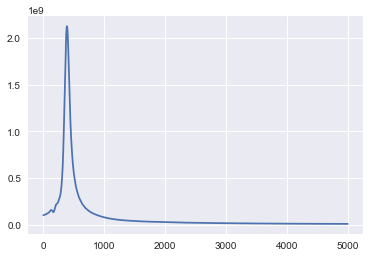

In [5]:
plt.plot(X_batch_t[5,2,:])

In [4]:
X_batch_max , y_batch_max = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 1362, freqOrTime='time', procFx = dp_ml.getMax)

In [6]:
X_batch_max , y_batch_max = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 1362, freqOrTime='time', procFx = dp_ml.getMaxAndEnergy)

In [7]:
print(X_batch_max.shape)
print(X_batch_max[0,0,:])

(1362, 5, 2)
[ 1.  1.]


(32, 5, 2)


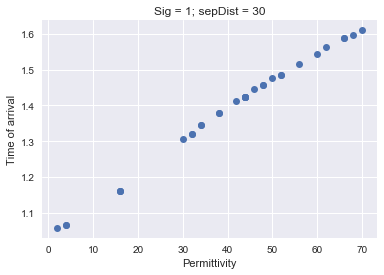

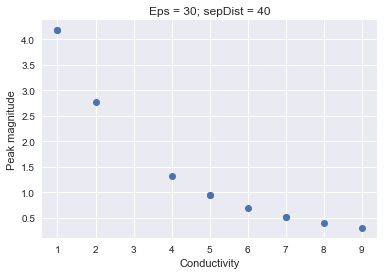

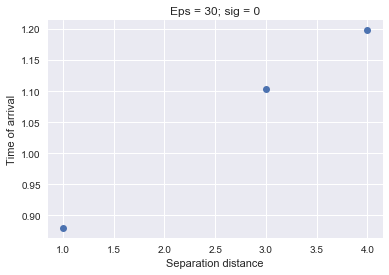

In [8]:
X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, sig = 8, sepDist = 3)
print(X_filt.shape)
plt.plot(y_filt[:,0], X_filt[:,2,1],'o')
plt.title('Sig = 1; sepDist = 30')
plt.xlabel('Permittivity')
plt.ylabel('Time of arrival')

X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, eps=20, sepDist = 1)
plt.figure()
plt.plot(y_filt[:,1], X_filt[:,2,0],'o')
plt.title('Eps = 30; sepDist = 40')
plt.xlabel('Conductivity')
plt.ylabel('Peak magnitude')

plt.figure()
X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, eps=10, sig = 1)
plt.plot(X_filt[:,0,0], X_filt[:,2,1],'o')
plt.title('Eps = 30; sig = 0')
plt.xlabel('Separation distance')
plt.ylabel('Time of arrival')

In [9]:
X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, eps=30, sig = 1)
print(X_filt[1,0,0])

2.0


### 2.1 Feature expansion:

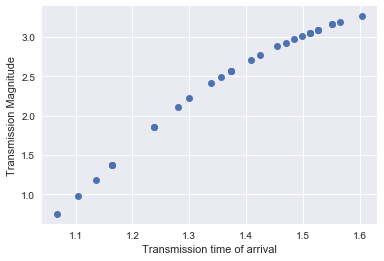

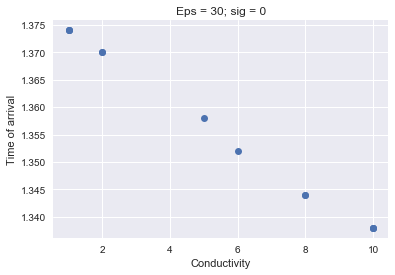

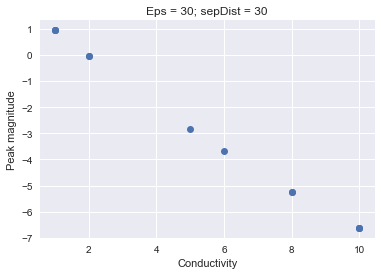

In [10]:
sig = 1


X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, sig = sig, sepDist = 3)

plt.figure()
plt.plot((X_filt[:,2,1]),X_filt[:,2,0],'o')
plt.xlabel('Transmission time of arrival')
plt.ylabel('Transmission Magnitude')


eps = 34


plt.figure()
X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, eps=eps, sepDist = 3)
plt.plot(y_filt[:,1], X_filt[:,2,1],'o')
plt.title('Eps = 30; sig = 0')
plt.xlabel('Conductivity')
plt.ylabel('Time of arrival')

X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, eps=eps, sepDist = 3)
plt.figure()
plt.plot(y_filt[:,1], np.log(X_filt[:,2,0]),'o')
plt.title('Eps = 30; sepDist = 30')
plt.xlabel('Conductivity')
plt.ylabel('Peak magnitude')

(16, 10, 5000)


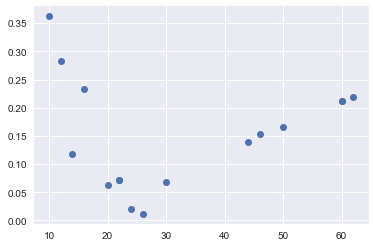

In [11]:
X_filt, y_filt = dp_ml.filterData(X_batch_test_f, y_batch_test_f, sig = 0, sepDist = 3)

print(X_filt.shape)
plt.plot(y_filt[:,0],X_filt[:,2,2500],'o')

In [19]:
X_batch_t, y_batch_t = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 1350, freqOrTime='time', procFx = dp_ml.procIdentity)
X_batch_f, y_batch_f = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 1350, freqOrTime='frequency', procFx = dp_ml.procIdentity)

In [20]:
print(X_batch_max.shape)

(1362, 5, 2)


## 3. Set up the learning method

### 3.1 Setting it up for getMax():

In [4]:
#init, saver, loss, training_op, X_ph, y, logits = dp_ml.setupModel(n_inputs = 10,n_hidden1 =10,n_hidden2=3, batch_size=15, activation_function = tf.nn.sigmoid)
#init, saver, loss, training_op, X_ph, y, logits = dp_ml.setupModel(n_inputs = 10,n_hidden1 =30,n_hidden2=10, batch_size=100, activation_function = tf.nn.sigmoid)
init, saver, loss, training_op, X_ph, y, logits = dp_ml.setupModel(n_inputs = 10,
                        n_hidden1 =200,n_hidden2=100, batch_size=100, 
                        activation_function = tf.nn.relu,opt="adam",
                        learning_rate = 0.001) # changed from 0.01 (10 May 2018)

## 4. Train the model

In [5]:
#dbFilename = '/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_07-Feb-2018.hdf5'
#dbFilename = '/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_11-Mar-2018.hdf5'
dbFilename = '/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_11-Mar-2018.hdf5'

dbFolder = 'Data/Simulation/CircWG'
#model_name = dp_ml.runModel(dbFilename, dbFolder, init, saver, loss, training_op, X_ph, y, procFx = dp_ml.getMax, freqOrTime = 'time',batch_size = 100, n_epochs = 10000)
model_name = dp_ml.runModel(dbFilename, dbFolder, init, saver, loss, training_op, X_ph, y, procFx = dp_ml.getMaxAndEnergy, freqOrTime = 'time',batch_size = 100, n_epochs = 1000)

Model filename:  ./Models/ANN_model_20180522-144723_1000-epochs_.ckpt
Instructions for updating:
Use `tf.global_variables_initializer` instead.
0 Train loss: 6.86535400391
1 Train loss: 3.75529418945
2 Train loss: 2.54924713135
3 Train loss: 2.44617752075
4 Train loss: 2.6791305542
5 Train loss: 1.90541946411
6 Train loss: 2.56886627197
7 Train loss: 1.89852325439
8 Train loss: 1.84323867798
9 Train loss: 2.06888885498
10 Train loss: 1.60175888062
11 Train loss: 1.73035354614
12 Train loss: 1.60246765137
13 Train loss: 1.80046859741
14 Train loss: 1.68609817505
15 Train loss: 1.566065979
16 Train loss: 2.04645385742
17 Train loss: 1.49026748657
18 Train loss: 1.33096664429
19 Train loss: 1.476355896
20 Train loss: 1.47068466187
21 Train loss: 1.34846832275
22 Train loss: 1.25344932556
23 Train loss: 1.1571156311
24 Train loss: 1.08669563293
25 Train loss: 1.06577362061
26 Train loss: 0.898355941772
27 Train loss: 0.903876495361
28 Train loss: 0.927341003418
29 Train loss: 0.93711181640

## 5. Predict from the model

In [7]:
#model_name = './Models/ANN_model_20180511-182150_10000-epochs_.ckpt'

np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})

ind = np.arange(40,50)
X_batch = X_batch_max[ind,:,:].reshape((10,10))
y_pred = dp_ml.predictFromModel(model_name, X_batch, saver, logits, X_ph)

print(X_batch)

# print separation distance too...
print(tabulate([['True eps: ', y_batch_max[ind,0]], ['Predicted eps: ', y_pred[:,0]], ['True sig: ',y_batch_max[ind,1]], ['Predicted sig: ', y_pred[:,1]]]))

INFO:tensorflow:Restoring parameters from ./Models/ANN_model_20180522-144723_1000-epochs_.ckpt
[[3.0 3.0 0.7 0.8 7.0 1.2 2.5 0.0 0.4 0.0]
 [1.0 1.0 1.9 0.8 0.6 0.9 0.2 0.0 0.8 0.0]
 [1.0 1.0 0.7 0.8 6.4 0.9 2.2 0.0 0.4 0.0]
 [3.0 3.0 1.8 0.8 0.3 1.6 0.1 0.0 0.7 0.0]
 [1.0 1.0 1.7 0.8 0.6 1.0 0.2 0.0 0.8 0.0]
 [1.0 1.0 2.6 0.8 0.2 0.9 0.1 0.0 1.1 0.0]
 [3.0 3.0 1.1 0.8 0.2 1.2 0.1 0.0 0.6 0.0]
 [1.0 1.0 2.2 0.8 6.1 1.1 2.2 0.0 1.5 0.0]
 [1.0 1.0 2.3 0.8 0.6 1.0 0.2 0.0 1.0 0.0]
 [2.0 2.0 0.9 1.6 6.1 1.2 2.1 0.0 0.9 0.0]]
--------------  --------------------------------------------------
True eps:       [18.0 14.0 17.0 64.0 32.0 6.0 20.0 78.0 66.0 38.0]
Predicted eps:  [18.3 14.1 17.6 64.1 32.6 6.5 20.4 78.9 66.6 37.8]
True sig:       [0.0 6.0 0.0 4.0 8.0 8.0 3.0 0.0 10.0 0.0]
Predicted sig:  [0.1 5.8 0.0 3.9 8.1 8.4 3.2 0.1 9.7 -0.0]
--------------  --------------------------------------------------


In [8]:
dbFile_test = h5py.File('/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_test_data_11-May-2018.hdf5')
dbFolder_test = 'Data/Simulation/CircWG'

X_batch_test , y_batch_test = dp_ml.getBatchFromDB(dbFile_test, dbFolder_test, 0,18, freqOrTime='time', procFx = dp_ml.getMaxAndEnergy)


INFO:tensorflow:Restoring parameters from ./Models/ANN_model_20180522-144723_1000-epochs_.ckpt
----------------  ---------------------------------------------------------------------------
True eps:         [66.2 31.4 31.4 31.4 31.4 66.2 66.2 31.4 66.2 66.2 31.4 66.2 66.2 66.2 66.2
                   31.4 31.4 66.2]
Predicted eps:    [63.3 29.5 31.4 31.1 31.4 63.5 63.3 31.6 63.4 63.3 31.4 63.4 63.5 63.4 63.4
                   31.4 31.2 63.3]
True sig:         [5.3 5.5 5.5 7.4 5.5 5.5 5.3 5.3 5.5 7.4 5.5 5.5 5.5 5.3 5.3 5.5 7.4 7.4]
Predicted sig:    [4.6 3.5 3.6 4.9 3.6 4.1 4.6 3.6 4.7 5.3 3.6 4.7 4.1 4.1 4.1 3.6 4.6 5.3]
Separation dist:  [1.4 2.9 1.4 1.4 1.4 1.7 1.4 1.7 1.4 1.7 1.4 1.4 1.7 1.7 1.7 1.4 1.7 1.7]
----------------  ---------------------------------------------------------------------------


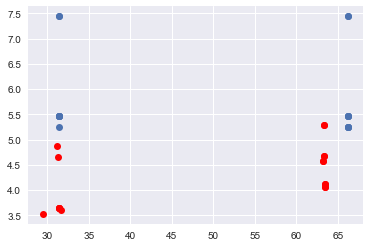

In [9]:
X_batch = X_batch_test.reshape((18,10))
y_pred = dp_ml.predictFromModel(model_name, X_batch, saver, logits, X_ph)

# print separation distance too...
print(tabulate([['True eps: ', y_batch_test[:,0]], ['Predicted eps: ', y_pred[:,0]], ['True sig: ',y_batch_test[:,1]], ['Predicted sig: ', y_pred[:,1]], ['Separation dist: ', X_batch[:,0]]]))

error = (y_batch_test[:,0] - y_pred[:,0])**2 + (y_batch_test[:,1] - y_pred[:,1])**2

#plt.plot(X_batch[:,0]%1, error,'o')
plt.plot(y_batch_test[:,0], y_batch_test[:,1],'o')
plt.plot(y_pred[:,0], y_pred[:,1],'or')

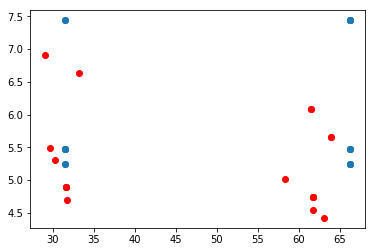

In [16]:
plt.plot(y_batch_test[:,0],y_batch_test[:,1],'o')
plt.plot(y_pred[:,0],y_pred[:,1],'or')


In [10]:
print(model_name)

./Models/ANN_model_20180511-182150_10000-epochs_.ckpt


In [35]:
t = np.zeros((2,5,2))
print(t.shape)

t = t.reshape(2,10)
print(t.shape)

(2, 5, 2)
(2, 10)


## Scrap code:

In [ ]:
interact(plotMagPhase,eps=widgets.IntSlider(min=2,max=70,step=2,value=26),
         sig=widgets.IntSlider(min=0,max=10,step=1,value=2),sepDist=widgets.IntSlider(min=10,max=50,step=10,value=30), 
         scale=widgets.FloatSlider(min=0.1,max=5.0,step=0.1,value=1.0, absPlot=True), 
         mode=['transmission','reflection'], domain = ['time', 'frequency']);